In [1]:
import numpy as np
import torch
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random
from preprocess import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# fix random seed
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)      
torch.cuda.manual_seed(0)
data_list = load_data()

# for X, Y in data_list:
#     X = zscore(X)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Seed_Autoencoder(nn.Module):
    def __init__(self, in_channels=5, feature_dim=64):
        super(Seed_Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),  # (16,8,9)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (16,4,4)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (32,4,4)
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # (32,2,2)
        )
        
        self.fc1 = nn.Linear(32*2*2, feature_dim)
        self.fc2 = nn.Linear(feature_dim, 32*2*2)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # (16,4,4)
            nn.ReLU(),
            nn.ConvTranspose2d(16, in_channels, kernel_size=2, stride=2, output_padding=(0,1)),  # (5,8,8)
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))  # bottleneck
        features = x.clone()      # 保存特征
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0),32,2,2)
        x = self.decoder(x)
        return x, features
    
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))    
        return x

In [25]:
batch_size = 32
lr = 1e-3
epochs = 10
n_classes = 3

def train_autoencoder(train_dataset, train_loader, test_dataset, test_loader):
    ae = Seed_Autoencoder().to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.MSELoss()

    ae.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb in train_loader:
            xb = xb[0].to(device)
            optimizer.zero_grad()
            out, _ = ae(xb)
            loss = criterion(out, xb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)
        train_loss = total_loss / len(train_dataset)

        ae.eval()
        with torch.no_grad():
            total_test_loss = 0
            for xb_test in test_loader:  
                xb_test = xb_test[0].to(device)
                out_test, _ = ae(xb_test)
                loss_test = criterion(out_test, xb_test)
                total_test_loss += loss_test.item() * xb_test.size(0)
            test_loss = total_test_loss / len(test_dataset)
        ae.train()  

        if (epoch+1) % 5 == 0 or True:
            print(f"AE Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return ae

ae_list = []

for i in [2]:
# for i in range(12):

    X_train, Y_train, X_test, Y_test = merge_data(data_list, i)
    X_train = get_CNN_data(X_train)
    X_test = get_CNN_data(X_test)

    train_dataset = SeedDataset(X_train, Y_train, augment=True)
    test_dataset = SeedDataset(X_test, Y_test, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    ae = train_autoencoder(train_dataset, train_loader, test_dataset, test_loader)
    ae_list.append(ae)

AE Epoch 1/10, Train Loss: 0.5357, Test Loss: 0.4354
AE Epoch 2/10, Train Loss: 0.4454, Test Loss: 0.4374
AE Epoch 3/10, Train Loss: 0.4309, Test Loss: 0.4290
AE Epoch 4/10, Train Loss: 0.4239, Test Loss: 0.4198
AE Epoch 5/10, Train Loss: 0.4203, Test Loss: 0.4165
AE Epoch 6/10, Train Loss: 0.4185, Test Loss: 0.4128
AE Epoch 7/10, Train Loss: 0.4161, Test Loss: 0.4124
AE Epoch 8/10, Train Loss: 0.4152, Test Loss: 0.4119
AE Epoch 9/10, Train Loss: 0.4123, Test Loss: 0.4102
AE Epoch 10/10, Train Loss: 0.4098, Test Loss: 0.4063


In [27]:
class Classifier(nn.Module):
    def __init__(self, feature_dim=64, num_classes=3):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(feature_dim, 32),  
            nn.ReLU(),                   
            nn.Dropout(0.5),            
            nn.Linear(32, num_classes)   
        )
    def forward(self,x):
        return self.fc(x)

In [28]:
clf_epoch = 20

clf_acc_list = []

for i in [2]:
# for i in range(12):

    X_train, Y_train, X_test, Y_test = merge_data(data_list, i)
    X_train = get_CNN_data(X_train)
    X_test = get_CNN_data(X_test)

    ae = ae_list[0]
    # ae = ae_list[i]
    ae.eval()
    with torch.no_grad():
        X_train_tensor = torch.tensor(X_train,dtype=torch.float32).to(device)
        _, feat_train = ae(X_train_tensor)
        X_test_tensor = torch.tensor(X_test,dtype=torch.float32).to(device)
        _, feat_test = ae(X_test_tensor)

    clf = Classifier().to(device)
    optimizer = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    train_dataset = SeedDataset(feat_train.to(device), torch.tensor(Y_train,dtype=torch.long), augment=False)
    train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_dataset = SeedDataset(feat_test.to(device), torch.tensor(Y_test,dtype=torch.long), augment=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

    print("Feature shape from AE:", feat_train.shape)

    for epoch in range(clf_epoch):
        clf.train()

        correct_train = 0
        total_train = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = clf(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

            pred = out.argmax(dim=1)
            correct_train += (pred == yb).sum().item()
            total_train += yb.size(0)

        train_acc = correct_train / total_train

        clf.eval()
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = clf(xb)
                loss = criterion(out, yb)

                pred = out.argmax(dim=1)
                correct_test += (pred == yb).sum().item()
                total_test += yb.size(0)

        test_acc = correct_test / total_test

        print(f"Epoch {epoch+1}/{clf_epoch}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
        if epoch == clf_epoch - 1: clf_acc_list.append(test_acc)



Feature shape from AE: torch.Size([27786, 64])


/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_i = torch.tensor(X_i, dtype=torch.float32)
/mnt/c/users/ValenciaLiu/Desktop/CS3319/HW2/preprocess.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_i = torch.tensor(Y_i, dtype=torch.long)


Epoch 1/20, Train Acc: 0.5598, Test Acc: 0.5633
Epoch 2/20, Train Acc: 0.6568, Test Acc: 0.5978
Epoch 3/20, Train Acc: 0.6849, Test Acc: 0.6148
Epoch 4/20, Train Acc: 0.7013, Test Acc: 0.5740
Epoch 5/20, Train Acc: 0.7212, Test Acc: 0.6279
Epoch 6/20, Train Acc: 0.7348, Test Acc: 0.5847
Epoch 7/20, Train Acc: 0.7394, Test Acc: 0.5934
Epoch 8/20, Train Acc: 0.7484, Test Acc: 0.5982
Epoch 9/20, Train Acc: 0.7539, Test Acc: 0.6378
Epoch 10/20, Train Acc: 0.7587, Test Acc: 0.6180
Epoch 11/20, Train Acc: 0.7576, Test Acc: 0.6132
Epoch 12/20, Train Acc: 0.7666, Test Acc: 0.6081
Epoch 13/20, Train Acc: 0.7725, Test Acc: 0.5831
Epoch 14/20, Train Acc: 0.7792, Test Acc: 0.6417
Epoch 15/20, Train Acc: 0.7801, Test Acc: 0.6441
Epoch 16/20, Train Acc: 0.7792, Test Acc: 0.6358
Epoch 17/20, Train Acc: 0.7850, Test Acc: 0.6235
Epoch 18/20, Train Acc: 0.7867, Test Acc: 0.6504
Epoch 19/20, Train Acc: 0.7841, Test Acc: 0.6267
Epoch 20/20, Train Acc: 0.7858, Test Acc: 0.6611


[0.32066508313539194, 0.3733174980205859, 0.549089469517023, 0.5890736342042755, 0.4231987331749802, 0.5205859065716548, 0.6397466349960411, 0.5277117973079969, 0.5589865399841647, 0.4350752177355503, 0.33016627078384797, 0.6433095803642122]
[0.32066508313539194, 0.3733174980205859, 0.549089469517023, 0.5890736342042755, 0.4231987331749802, 0.5205859065716548, 0.6397466349960411, 0.5277117973079969, 0.5589865399841647, 0.4350752177355503, 0.33016627078384797, 0.6433095803642122]
LOSO Mean Accuracy: 0.4926, Std: 0.1086


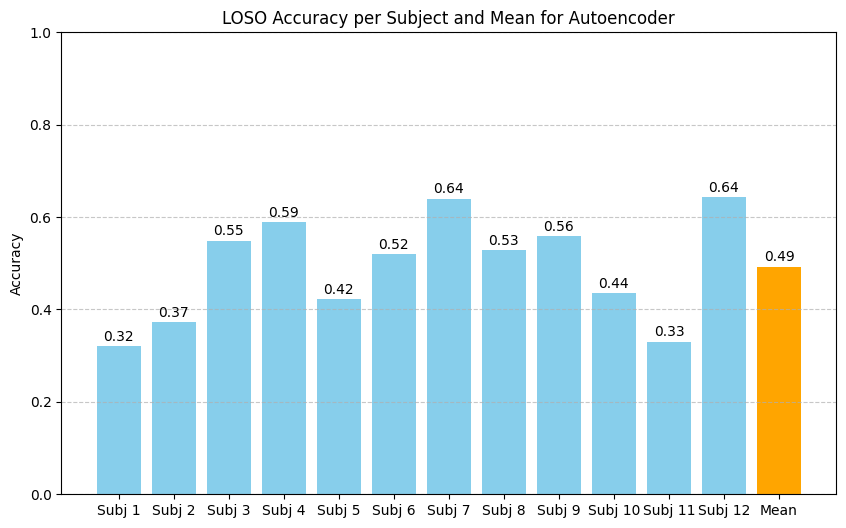

In [24]:
print(clf_acc_list)

print(clf_acc_list)
mean_acc = np.mean(clf_acc_list)
std_acc = np.std(clf_acc_list)
print(f"LOSO Mean Accuracy: {mean_acc:.4f}, Std: {std_acc:.4f}")

x_labels = [f"Subj {i}" for i in range(1, 13)] + ["Mean"]
# 对应柱子高度
y_values = clf_acc_list + [mean_acc]

# 绘制柱状图
plt.figure(figsize=(10,6))
bars = plt.bar(x_labels, y_values, color=['skyblue']*12 + ['orange'])

# 在柱子上显示数值
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f"{height:.2f}", ha='center', va='bottom')

plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("LOSO Accuracy per Subject and Mean for Autoencoder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

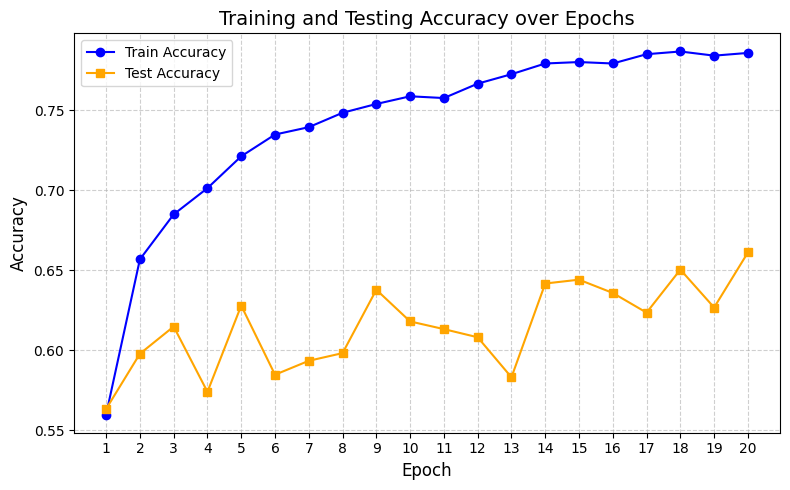

In [ ]:
epochs = list(range(1, 21))
train_acc = [0.5598, 0.6568, 0.6849, 0.7013, 0.7212, 0.7348, 0.7394, 0.7484, 0.7539, 0.7587,
             0.7576, 0.7666, 0.7725, 0.7792, 0.7801, 0.7792, 0.7850, 0.7867, 0.7841, 0.7858]
test_acc = [0.5633, 0.5978, 0.6148, 0.5740, 0.6279, 0.5847, 0.5934, 0.5982, 0.6378, 0.6180,
            0.6132, 0.6081, 0.5831, 0.6417, 0.6441, 0.6358, 0.6235, 0.6504, 0.6267, 0.6611]

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy', color='blue')
plt.plot(epochs, test_acc, marker='s', label='Test Accuracy', color='orange')

plt.title('Training and Testing Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# 显示
plt.show()